# Benchmark de batch size

🚀 Iniciando Benchmark OMP Batch
Usando device: cuda
Generando datos sintéticos...
Dimensiones: X=torch.Size([1024, 1024]), Y=torch.Size([500000, 1024])
Calentando GPU...

Iniciando benchmark...
Evaluando batch_size = 50
  📊 RESULTADOS:
    Dataset completo: 136.284±2.598s
    Tiempo por batch: 13.62±0.26ms
    Memoria máxima: 7.0±0.0 MB
    Memoria total: 0.0±0.0 MB
    Throughput: 3668.8 muestras/s

Evaluando batch_size = 100
  📊 RESULTADOS:
    Dataset completo: 69.403±3.446s
    Tiempo por batch: 13.87±0.69ms
    Memoria máxima: 10.0±0.0 MB
    Memoria total: 0.0±0.0 MB
    Throughput: 7204.3 muestras/s

Evaluando batch_size = 250
  📊 RESULTADOS:
    Dataset completo: 27.475±0.115s
    Tiempo por batch: 13.73±0.06ms
    Memoria máxima: 19.0±0.0 MB
    Memoria total: 0.0±0.0 MB
    Throughput: 18198.6 muestras/s

Evaluando batch_size = 500
  📊 RESULTADOS:
    Dataset completo: 16.409±0.054s
    Tiempo por batch: 16.40±0.05ms
    Memoria máxima: 34.6±0.0 MB
    Memoria total: 0.0±0.0 

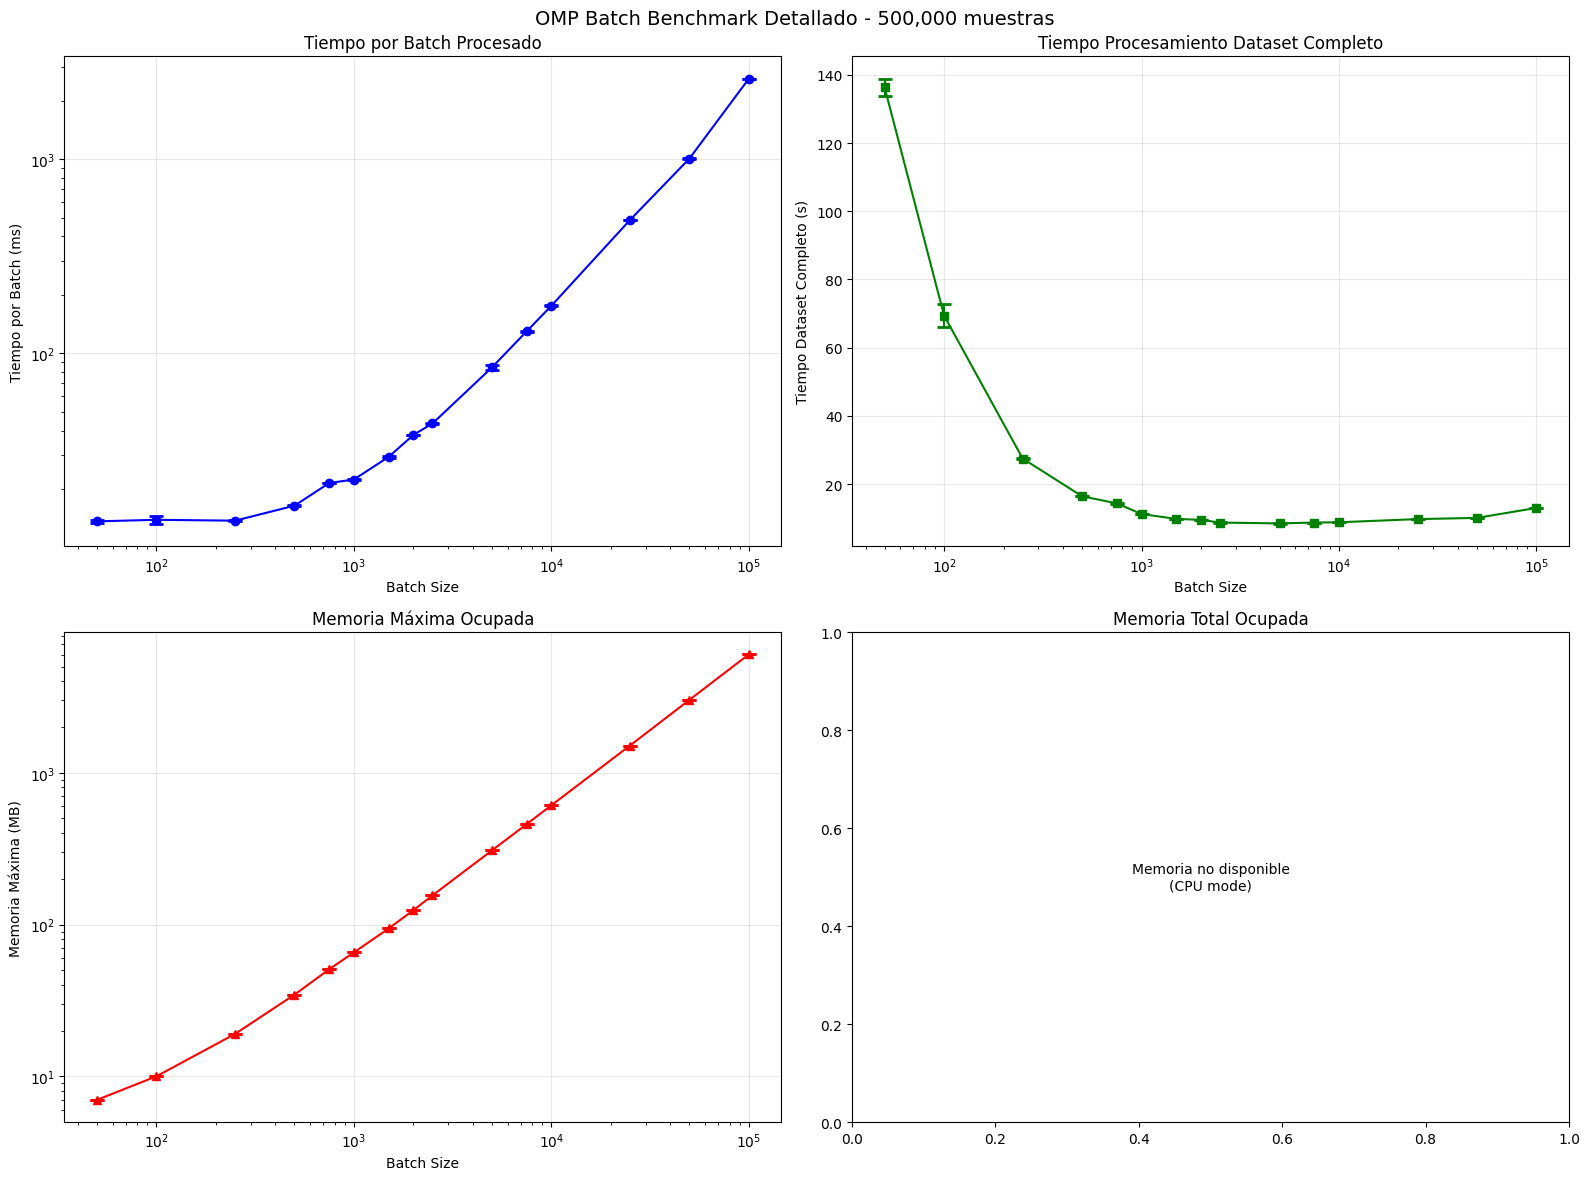


📊 Resultados guardados en:
  - omp_batch_benchmark.csv
  - omp_batch_benchmark.png


In [2]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ompingpu import omp_batch
import gc

def benchmark_omp_batch():
    """
    Evalúa métricas específicas de omp_batch:
    - Memoria máxima ocupada
    - Tiempo por batch procesado
    - Tiempo en procesar dataset completo
    - Memoria total ocupada en cada procesamiento
    """
    
    # Configuración del benchmark
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Usando device: {device}")
    
    # Parámetros fijos del problema
    n_samples = 500000      # Número total de señales
    signal_length = 1024    # Longitud de cada señal
    dict_size = 1024       # Tamaño del diccionario
    n_nonzero_coefs = 10   # Coeficientes no ceros
    
    # Tamaños de batch a evaluar                                                            
    batch_sizes = [50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 5000, 7500, 10000, 25000, 50000, 100000]
    
    # Generar datos sintéticos
    print("Generando datos sintéticos...")
    torch.manual_seed(42)  # Para reproducibilidad
    
    # Diccionario normalizado
    X = torch.randn(dict_size, signal_length, device=device, dtype=torch.float32)
    X = X / torch.norm(X, dim=1, keepdim=True)  # Normalizar columnas
    
    # Señales sintéticas (esparse)
    Y = torch.randn(n_samples, signal_length, device=device, dtype=torch.float32)
    
    print(f"Dimensiones: X={X.shape}, Y={Y.shape}")
    
    # Calentamiento de GPU
    if device == 'cuda':
        print("Calentando GPU...")
        _ = omp_batch(X.T, Y[:100].T, n_nonzero_coefs, batch_size=50)
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    
    # Almacenar resultados
    results = []
    
    print("\nIniciando benchmark...")
    print("=" * 80)
    
    for batch_size in batch_sizes:
        print(f"Evaluando batch_size = {batch_size}")
        
        # Métricas por ejecución
        dataset_times = []
        max_memories = []
        total_memories = []
        batch_times = []
        
        for run in range(3):  # 3 repeticiones
            if device == 'cuda':
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()
                torch.cuda.synchronize()
                baseline_memory = torch.cuda.memory_allocated()
            
            # Calcular número de batches
            num_batches = (n_samples + batch_size - 1) // batch_size
            
            # Medir tiempo total del dataset
            dataset_start = time.time()
            
            # Simular procesamiento por batches para medir tiempo individual
            individual_batch_times = []
            
            for i in range(0, n_samples, batch_size):
                end_idx = min(i + batch_size, n_samples)
                batch_data = Y[i:end_idx]
                
                batch_start = time.time()
                
                # Ejecutar OMP para este batch
                result_batch = omp_batch(X.T, batch_data.T, n_nonzero_coefs, batch_size=batch_size)
                
                if device == 'cuda':
                    torch.cuda.synchronize()
                
                batch_end = time.time()
                individual_batch_times.append(batch_end - batch_start)
                
                del result_batch
            
            dataset_end = time.time()
            
            # Métricas de tiempo
            total_dataset_time = dataset_end - dataset_start
            avg_batch_time = np.mean(individual_batch_times)
            
            dataset_times.append(total_dataset_time)
            batch_times.append(avg_batch_time)
            
            # Métricas de memoria
            if device == 'cuda':
                peak_memory = torch.cuda.max_memory_allocated()
                current_memory = torch.cuda.memory_allocated()
                
                max_memory_used = (peak_memory - baseline_memory) / 1024**2  # MB
                total_memory_used = (current_memory - baseline_memory) / 1024**2  # MB
                
                max_memories.append(max_memory_used)
                total_memories.append(total_memory_used)
                
                torch.cuda.empty_cache()
            
            gc.collect()
        
        # Estadísticas finales
        avg_dataset_time = np.mean(dataset_times)
        std_dataset_time = np.std(dataset_times)
        avg_batch_time = np.mean(batch_times)
        std_batch_time = np.std(batch_times)
        
        if device == 'cuda':
            avg_max_memory = np.mean(max_memories)
            std_max_memory = np.std(max_memories)
            avg_total_memory = np.mean(total_memories)
            std_total_memory = np.std(total_memories)
        else:
            avg_max_memory = avg_total_memory = 0
            std_max_memory = std_total_memory = 0
        
        # Métricas derivadas
        throughput = n_samples / avg_dataset_time
        batches_per_second = (n_samples / batch_size) / avg_dataset_time
        
        result = {
            'batch_size': batch_size,
            'num_batches': (n_samples + batch_size - 1) // batch_size,
            
            # Tiempo por batch procesado
            'avg_batch_time': avg_batch_time,
            'std_batch_time': std_batch_time,
            'batch_time_ms': avg_batch_time * 1000,
            
            # Tiempo dataset completo
            'avg_dataset_time': avg_dataset_time,
            'std_dataset_time': std_dataset_time,
            
            # Memoria máxima ocupada
            'max_memory_mb': avg_max_memory,
            'std_max_memory_mb': std_max_memory,
            
            # Memoria total ocupada
            'total_memory_mb': avg_total_memory,
            'std_total_memory_mb': std_total_memory,
            
            # Métricas adicionales
            'throughput_samples_per_sec': throughput,
            'batches_per_second': batches_per_second,
            'memory_per_sample_kb': (avg_max_memory * 1024) / batch_size if avg_max_memory > 0 else 0
        }
        
        results.append(result)
        
        print(f"  📊 RESULTADOS:")
        print(f"    Dataset completo: {avg_dataset_time:.3f}±{std_dataset_time:.3f}s")
        print(f"    Tiempo por batch: {avg_batch_time*1000:.2f}±{std_batch_time*1000:.2f}ms")
        print(f"    Memoria máxima: {avg_max_memory:.1f}±{std_max_memory:.1f} MB")
        print(f"    Memoria total: {avg_total_memory:.1f}±{std_total_memory:.1f} MB")
        print(f"    Throughput: {throughput:.1f} muestras/s")
        print()
    
    return results, {'n_samples': n_samples, 'signal_length': signal_length, 
                    'dict_size': dict_size, 'n_nonzero_coefs': n_nonzero_coefs}

def plot_results(results, config):
    """Grafica los resultados del benchmark enfocado en las métricas específicas"""
    
    df = pd.DataFrame(results)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'OMP Batch Benchmark Detallado - {config["n_samples"]:,} muestras', fontsize=14)
    
    # 1. Tiempo por batch procesado
    ax1.errorbar(df['batch_size'], df['batch_time_ms'], yerr=df['std_batch_time']*1000, 
                marker='o', capsize=5, capthick=2, color='blue')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Tiempo por Batch (ms)')
    ax1.set_title('Tiempo por Batch Procesado')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # 2. Tiempo dataset completo
    ax2.errorbar(df['batch_size'], df['avg_dataset_time'], yerr=df['std_dataset_time'], 
                marker='s', capsize=5, capthick=2, color='green')
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Tiempo Dataset Completo (s)')
    ax2.set_title('Tiempo Procesamiento Dataset Completo')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    
    # 3. Memoria máxima ocupada
    if df['max_memory_mb'].sum() > 0:
        ax3.errorbar(df['batch_size'], df['max_memory_mb'], yerr=df['std_max_memory_mb'], 
                    marker='^', capsize=5, capthick=2, color='red')
        ax3.set_xlabel('Batch Size')
        ax3.set_ylabel('Memoria Máxima (MB)')
        ax3.set_title('Memoria Máxima Ocupada')
        ax3.grid(True, alpha=0.3)
        ax3.set_xscale('log')
        ax3.set_yscale('log')
    else:
        ax3.text(0.5, 0.5, 'Memoria no disponible\n(CPU mode)', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Memoria Máxima Ocupada')
    
    # 4. Memoria total ocupada
    if df['total_memory_mb'].sum() > 0:
        ax4.errorbar(df['batch_size'], df['total_memory_mb'], yerr=df['std_total_memory_mb'], 
                    marker='d', capsize=5, capthick=2, color='purple')
        ax4.set_xlabel('Batch Size')
        ax4.set_ylabel('Memoria Total (MB)')
        ax4.set_title('Memoria Total Ocupada')
        ax4.grid(True, alpha=0.3)
        ax4.set_xscale('log')
    else:
        ax4.text(0.5, 0.5, 'Memoria no disponible\n(CPU mode)', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Memoria Total Ocupada')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_summary(results, config):
    """Imprime un resumen detallado de las métricas específicas"""
    
    df = pd.DataFrame(results)
    
    print("RESUMEN DETALLADO DEL BENCHMARK")
    print("=" * 70)
    print(f"Configuración:")
    print(f"  - Muestras totales: {config['n_samples']:,}")
    print(f"  - Longitud señal: {config['signal_length']}")
    print(f"  - Tamaño diccionario: {config['dict_size']}")
    print(f"  - Coeficientes no-cero: {config['n_nonzero_coefs']}")
    print()
    
    # ANÁLISIS DE TIEMPO POR BATCH
    print("📊 ANÁLISIS DE TIEMPO POR BATCH:")
    fastest_batch_idx = df['avg_batch_time'].idxmin()
    slowest_batch_idx = df['avg_batch_time'].idxmax()
    
    print(f"  Batch más rápido: {df.iloc[fastest_batch_idx]['batch_size']} "
          f"({df.iloc[fastest_batch_idx]['batch_time_ms']:.2f} ms/batch)")
    print(f"  Batch más lento: {df.iloc[slowest_batch_idx]['batch_size']} "
          f"({df.iloc[slowest_batch_idx]['batch_time_ms']:.2f} ms/batch)")
    print()
    
    # ANÁLISIS DE DATASET COMPLETO
    print("📊 ANÁLISIS DE DATASET COMPLETO:")
    fastest_dataset_idx = df['avg_dataset_time'].idxmin()
    slowest_dataset_idx = df['avg_dataset_time'].idxmax()
    
    print(f"  Procesamiento más rápido: batch_size={df.iloc[fastest_dataset_idx]['batch_size']} "
          f"({df.iloc[fastest_dataset_idx]['avg_dataset_time']:.2f}s)")
    print(f"  Procesamiento más lento: batch_size={df.iloc[slowest_dataset_idx]['batch_size']} "
          f"({df.iloc[slowest_dataset_idx]['avg_dataset_time']:.2f}s)")
    print(f"  Mejor throughput: {df.iloc[fastest_dataset_idx]['throughput_samples_per_sec']:.1f} muestras/s")
    print()
    
    # ANÁLISIS DE MEMORIA
    if df['max_memory_mb'].sum() > 0:
        print("📊 ANÁLISIS DE MEMORIA:")
        min_memory_idx = df['max_memory_mb'].idxmin()
        max_memory_idx = df['max_memory_mb'].idxmax()
        
        print(f"  Menor memoria máxima: batch_size={df.iloc[min_memory_idx]['batch_size']} "
              f"({df.iloc[min_memory_idx]['max_memory_mb']:.1f} MB)")
        print(f"  Mayor memoria máxima: batch_size={df.iloc[max_memory_idx]['batch_size']} "
              f"({df.iloc[max_memory_idx]['max_memory_mb']:.1f} MB)")
        
        # Eficiencia de memoria
        df['memory_efficiency'] = df['batch_size'] / df['max_memory_mb']
        most_efficient_idx = df['memory_efficiency'].idxmax()
        print(f"  Más eficiente memoria: batch_size={df.iloc[most_efficient_idx]['batch_size']} "
              f"({df.iloc[most_efficient_idx]['memory_per_sample_kb']:.2f} KB/muestra)")
        print()
    
    # RECOMENDACIONES
    print("🎯 RECOMENDACIONES:")
    
    # Encontrar el batch size óptimo (balance tiempo-memoria)
    if df['max_memory_mb'].sum() > 0:
        # Normalizar métricas para encontrar balance
        df_norm = df.copy()
        df_norm['norm_time'] = (df_norm['avg_dataset_time'] - df_norm['avg_dataset_time'].min()) / (df_norm['avg_dataset_time'].max() - df_norm['avg_dataset_time'].min())
        df_norm['norm_memory'] = (df_norm['max_memory_mb'] - df_norm['max_memory_mb'].min()) / (df_norm['max_memory_mb'].max() - df_norm['max_memory_mb'].min())
        df_norm['balance_score'] = df_norm['norm_time'] + df_norm['norm_memory']
        
        optimal_idx = df_norm['balance_score'].idxmin()
        optimal_batch = df.iloc[optimal_idx]['batch_size']
        
        print(f"  Batch size óptimo (balance tiempo-memoria): {optimal_batch}")
        print(f"    - Tiempo dataset: {df.iloc[optimal_idx]['avg_dataset_time']:.2f}s")
        print(f"    - Memoria máxima: {df.iloc[optimal_idx]['max_memory_mb']:.1f} MB")
        print(f"    - Throughput: {df.iloc[optimal_idx]['throughput_samples_per_sec']:.1f} muestras/s")
    else:
        print(f"  Batch size óptimo (menor tiempo): {df.iloc[fastest_dataset_idx]['batch_size']}")
    
    print()
    
    # TABLA COMPLETA DE RESULTADOS
    print("📋 TABLA DETALLADA DE RESULTADOS:")
    print("-" * 120)
    
    # Seleccionar columnas importantes para mostrar
    display_cols = ['batch_size', 'num_batches', 'batch_time_ms', 'avg_dataset_time', 
                   'max_memory_mb', 'total_memory_mb', 'throughput_samples_per_sec']
    
    display_df = df[display_cols].copy()
    display_df.columns = ['Batch Size', 'Num Batches', 'Tiempo/Batch (ms)', 
                         'Tiempo Dataset (s)', 'Mem Max (MB)', 'Mem Total (MB)', 'Throughput (muestras/s)']
    
    print(display_df.to_string(index=False, float_format='%.2f'))
    
    return df

# Función principal para ejecutar todo
def run_benchmark():
    """Ejecuta el benchmark completo"""
    
    print("🚀 Iniciando Benchmark OMP Batch")
    print("=" * 50)
    
    # Ejecutar benchmark
    results, config = benchmark_omp_batch()
    
    # Mostrar resumen
    df = print_summary(results, config)
    
    # Graficar resultados
    fig = plot_results(results, config)
    
    # Guardar resultados
    df.to_csv('omp_batch_benchmark.csv', index=False)
    fig.savefig('omp_batch_benchmark.png', dpi=300, bbox_inches='tight')
    
    print(f"\n📊 Resultados guardados en:")
    print(f"  - omp_batch_benchmark.csv")
    print(f"  - omp_batch_benchmark.png")
    
    return results, config

if __name__ == "__main__":
    results, config = run_benchmark()

### Con un batch_size de 200000, se supero los 12Gb de memoria en la GPU. un batch-size de 100000 ya es el limite

Estimasion de la memoria ocupada en funcion a la cantidad de señales utilizadas y su longitud

    # Parámetros fijos del problema
    n_samples = 500000      # Número total de señales
    signal_length = 512    # Longitud de cada señal
    dict_size = 1024       # Tamaño del diccionario
    n_nonzero_coefs = 10   # Coeficientes no ceros
    
    # Tamaños de batch a evaluar                                                            
    batch_sizes = [50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 5000, 7500, 10000, 25000, 50000, 100000]

In [ ]:
# La dependencia se da por la cantidad de muestras en el batch, su longitud y la cantidad de coeficientes no nulos (que establece la dimension de la matriz inversa)

total = 500000 
signal_length = 512 
batch_utilizado = 50
n_nonzero_coefs = 10

# Veremos igual si existe una relacion lineal o mas sencilla para la funcion Mem(batch_size)
